In [22]:
import time
import pandas as pd
import numpy as np
import datetime
import os
import gc
from functools import partial
import matplotlib.pyplot as plt
from utils import load_data, get_logger, get_data_path
from clean_session import preprocess_sessions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_input = pd.read_parquet('./cache/train_inputs_no_imp.snappy')

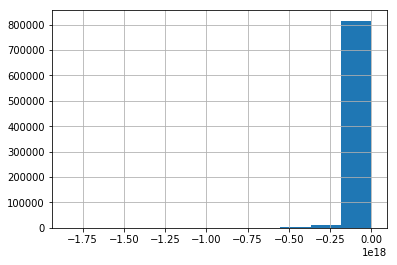

In [7]:
train_input.price_24.hist()

In [8]:
train_input[[f'price_{i}' for i in range(25)]].describe()

,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,...,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24
count,826505.000000,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,...,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05,8.265050e+05
mean,0.484429,-6.466336e+14,-1.149055e+15,-1.609935e+15,-2.052240e+15,-2.478190e+15,-2.893022e+15,-3.296869e+15,-3.684673e+15,-4.097316e+15,...,-9.500502e+15,-1.032152e+16,-1.105540e+16,-1.175626e+16,-1.242686e+16,-1.307715e+16,-1.367246e+16,-1.424511e+16,-1.482179e+16,-1.720338e+16
std,0.277448,1.424727e+16,1.746358e+16,1.966636e+16,2.130881e+16,2.266442e+16,2.379419e+16,2.476802e+16,2.562760e+16,2.647925e+16,...,3.831479e+16,3.979293e+16,4.095023e+16,4.206578e+16,4.307594e+16,4.404481e+16,4.490763e+16,4.563676e+16,4.633630e+16,4.920183e+16
min,0.001002,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,...,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18,-1.844674e+18
25%,0.260417,2.626263e-01,2.587940e-01,2.538071e-01,2.505308e-01,2.450142e-01,2.398568e-01,2.352941e-01,2.311828e-01,2.246575e-01,...,1.690821e-01,1.601942e-01,1.521036e-01,1.428571e-01,1.347150e-01,1.260504e-01,1.173469e-01,1.088083e-01,9.937888e-02,4.182510e-02
50%,0.444089,4.400000e-01,4.351145e-01,4.292683e-01,4.263566e-01,4.197531e-01,4.150943e-01,4.107143e-01,4.068627e-01,4.015748e-01,...,3.533569e-01,3.468208e-01,3.397436e-01,3.333333e-01,3.283582e-01,3.225806e-01,3.166667e-01,3.121597e-01,3.070539e-01,2.871972e-01
75%,0.680000,6.586826e-01,6.534653e-01,6.490385e-01,6.470588e-01,6.433566e-01,6.408163e-01,6.379310e-01,6.360656e-01,6.320755e-01,...,5.882353e-01,5.808824e-01,5.759494e-01,5.714286e-01,5.644654e-01,5.598086e-01,5.569620e-01,5.508982e-01,5.458333e-01,5.320122e-01
max,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [29]:
from create_model_inputs import compute_session_fts, prepare_data, flogger

In [14]:
logger = get_logger('create_model_inputs')
Filepath = get_data_path()


In [41]:
mode='train'
nrows=1000000
logger.info(f'Prepare {mode} data')
t_init = time.time()
df = prepare_data(mode, convert_action_type=True, nrows=nrows, recompute=False)
logger.info('Compute session features')

[05-17 21:29:26 - create_model_inputs-3 - <module> - INFO] Prepare train data
[05-17 21:29:27 - utils-106 - load_data - INFO] Loading train using 1,000,000 rows (999,995 trimmed) which is 6.28% out of total train data
[05-17 21:29:27 - create_model_inputs-17 - flogger - INFO] raw train shape: (999,995, 12)
[05-17 21:29:27 - clean_session-56 - preprocess_sessions - INFO] Load from existing file: ./cache/preprocessed_train.snappy
[05-17 21:29:28 - create_model_inputs-74 - prepare_data - INFO] Converting action_types to int (natural number)
[05-17 21:29:28 - create_model_inputs-25 - create_action_type_mapping - INFO] Load action_types mapping from existing: ./cache/action_types_mapping.npy
[05-17 21:29:28 - create_model_inputs-77 - prepare_data - INFO] Sort df by user_id, session_id, timestamp, step
[05-17 21:29:28 - create_model_inputs-17 - flogger - INFO] Prepared train data shape: (326,695, 9)
[05-17 21:29:28 - create_model_inputs-6 - <module> - INFO] Compute session features


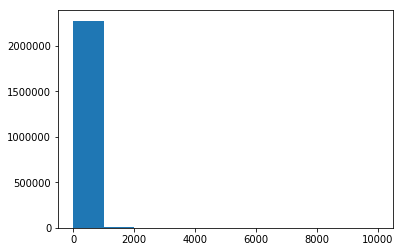

In [42]:
str_prices = np.concatenate(df.prices.dropna().str.split('|').values)
str_prices = [int(sp) for sp in str_prices]
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [25]:
%%time
df = compute_session_fts(df, mode)

[05-17 21:24:03 - create_model_inputs-125 - compute_session_fts - INFO] Session features generated: ['timestamp_session_duration', 'timestamp_dwell_time_prior_clickout', 'session_id_size']


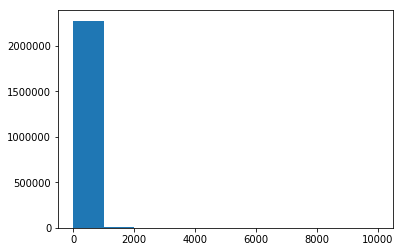

In [43]:
str_prices = np.concatenate(df.prices.dropna().str.split('|').values)
str_prices = [int(sp) for sp in str_prices]
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [44]:
logger.info('Only select last click-out from each session')
df = df.groupby('session_id').last().reset_index()
flogger(df, 'df shape after only selecting last click-out row each session')

# # log-transform on session_size feature
# logger.info('Log-transform on session_size feature')
# df['session_id_size'] = np.log(df['session_id_size'])

# # log1p-transform on timestamp_dwell_time_prior_clickout but will cliping upper to 1hr
# logger.info('Also log-transform on timestamp_dwell_time_prior_clickout but will cliping upper to 1hr')
# df['timestamp_dwell_time_prior_clickout'] = np.log1p(df['timestamp_dwell_time_prior_clickout'].clip(upper=60 ** 2))

[05-17 21:29:47 - create_model_inputs-1 - <module> - INFO] Only select last click-out from each session
[05-17 21:29:47 - create_model_inputs-17 - flogger - INFO] df shape after only selecting last click-out row each session shape: (51,962, 9)


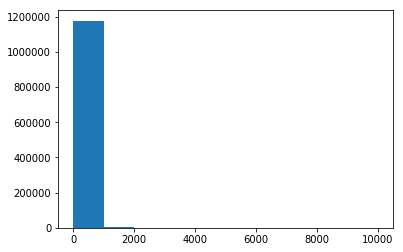

In [45]:
str_prices = np.concatenate(df.prices.dropna().str.split('|').values)
str_prices = [int(sp) for sp in str_prices]
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [46]:
df['prices'] = df['prices'].str.split('|')
df['prices_int'] = df['prices'].apply(lambda x: [int(p) for p in x])

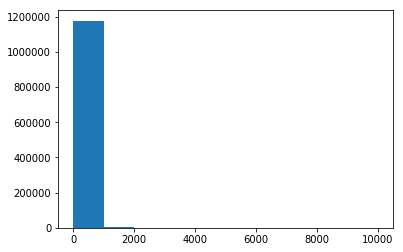

In [47]:
str_prices = np.concatenate(df.prices_int.dropna().values)
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [48]:
df['time_steps'] = df['prices_int'].str.len()
padding_mask = df['time_steps'] < 25
df.drop('time_steps', axis=1, inplace=True)

In [51]:
df.prices.head()

0    [74, 88, 87, 72, 56, 87, 244, 168, 123, 50, 12...
1    [79, 241, 96, 51, 68, 99, 86, 69, 71, 79, 91, ...
2    [466, 193, 295, 331, 171, 347, 383, 557, 106, ...
3    [144, 372, 139, 141, 109, 84, 74, 168, 78, 89,...
4    [97, 101, 78, 75, 99, 60, 120, 78, 188, 136, 9...
Name: prices, dtype: object

In [52]:
df.prices.iloc[0]

['74',
 '88',
 '87',
 '72',
 '56',
 '87',
 '244',
 '168',
 '123',
 '50',
 '129',
 '72',
 '151',
 '83',
 '230',
 '88',
 '59',
 '450',
 '138',
 '88',
 '100',
 '111',
 '185',
 '72',
 '37']

In [58]:
df[df.prices.str.len()<25].prices.iloc[0]

['144',
 '372',
 '139',
 '141',
 '109',
 '84',
 '74',
 '168',
 '78',
 '89',
 '100',
 '68',
 '139',
 '189']

In [73]:
x = [int(i) for i in df[df.prices.str.len()<25].prices.iloc[0]]
x

[144, 372, 139, 141, 109, 84, 74, 168, 78, 89, 100, 68, 139, 189]

In [74]:
np.pad(x, (0, 25-len(x)), mode='constant', constant_values=0)

array([144, 372, 139, 141, 109,  84,  74, 168,  78,  89, 100,  68, 139,
       189,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [70]:
type(np.nan)

float

In [49]:
df.loc[padding_mask, 'prices_int'] = df.loc[padding_mask, 'prices_int'].apply(lambda x: np.pad(x, (0, 25-len(x)),
                                                                                       mode='constant',
                                                                                       constant_values=np.nan))

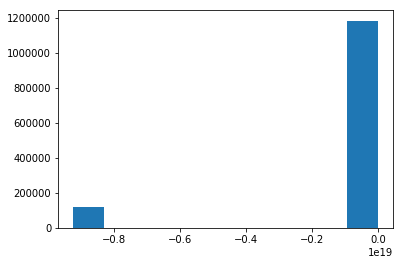

In [50]:
str_prices = np.concatenate(df.prices_int.dropna().values)
# pd.value_counts(str_prices)
_ = plt.hist(str_prices)

In [ ]:
def normalize(ps):
    p_arr = np.array(ps)
    return p_arr / (p_arr.max())
df['prices_percentage_int'] = df['prices'].apply(normalize)